In [15]:
import PIL
import jax.numpy as jnp
from tensorflow.io import gfile
from scenic.projects.boundary_attention.configs import base_config
from scenic.projects.boundary_attention.helpers import train_utils
from scenic.projects.boundary_attention.helpers import viz_utils

import tensorflow_datasets as tfds
import scenic.projects.boundary_attention.kaleidoshapes.kaleidoshapes

import ml_collections
import jax

from scenic.projects.boundary_attention.dataset_lib import dataloader
from scenic.projects.boundary_attention.configs import kaleidoshapes_config
from scenic.projects.boundary_attention.dataset_lib.datasets import kaleidoshapes_dataset

import matplotlib.pyplot as plt

import numpy as np
from skimage.filters import gaussian

In [17]:
def create_dataloader(batch_size, 
                      dataset_dir = 'scenic/projects/boundary_attention/kaleidoshapes_dataset/kaleidoshapes',
                      rng_seed = 0, 
                      imshape = (125,125,3)
                     ):
    #intialize config
    config = ml_collections.ConfigDict()
    
    #config settings
    config.dataset = kaleidoshapes_config.get_config_kaleidoshapes(dataset_dir)
    config.dataset.crop_size = imshape
    config.batch_size = batch_size
    config.eval_batch_size = batch_size
    
    #create_dataloader
    kaleidoshapes_dataset = dataloader.get_dataloader(config, jax.random.PRNGKey(rng_seed))

    return(kaleidoshapes_dataset)

In [19]:
def create_model_BA(weights_dir = 'scenic/projects/boundary_attention/pretrained_weights/', 
                    imshape = (125,125,3)):
    config = base_config.get_config(model_name='boundary_attention',
                                  dataset_name='testing',
                                  input_size=imshape)
    return train_utils.make_apply(config, weights_dir) # tuple: (apply_jitted, trained_params)

In [105]:
def apply_noise(img, sigma):
    return img + np.random.normal(0, sigma, img.shape) 

In [191]:
def create_batch(data_loader,
                 boundary_model, # tuple: (apply_jitted, trained_params)
                 noise_levels = [0.1], 
                 num_images_per_level = 1
                ):
    
    next_batch = next(data_loader.train_iter)

    processed_batch = {}

    for i in range(next_batch['segments'].shape[1]):
        img_out = []
        for noise in noise_levels:
            for j in range(num_images_per_level):
                img_arr = np.moveaxis(np.array(next_batch['segments'][0, i, :, :, :]), 0, 2)

                noisy_img = apply_noise(img_arr, noise)
                
                img = PIL.Image.fromarray(noisy_img.astype(np.uint8)[:,:,0], mode='L').convert("RGB")
                img = jnp.array(img)/255
                
                input_img = jnp.expand_dims(img.transpose(2,0,1)[:3,:,:], axis=0)
    
                outputs = boundary_model[0](boundary_model[1]['params'], input_img)

                #boundaries = (outputs[-1]['global_boundaries'].squeeze() * (
                #              outputs[-1]['global_boundaries'].squeeze() > .3))[8:-8, 8:-8]

                boundaries = outputs[-1]['global_boundaries'].squeeze()

                img_out.append((img_arr, noise, noisy_img, boundaries))

            
        processed_batch[i] = img_out

    return processed_batch

In [218]:
def plot_outputs(out_list): # out_list = (img_arr, noise, noisy_img, boundaries)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    #plt.subplots_adjust(wspace=-0.55, hspace=0.2)
    
    ax[0].imshow(out_list[0])
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(out_list[2])
    ax[1].set_title('Noisy Image')
    ax[1].axis('off')

    ax[2].imshow(out_list[3], cmap = "grey")
    ax[2].set_title('Boundary Output')
    ax[2].axis('off')

In [193]:
batch = create_batch(create_dataloader(1), create_model_BA())

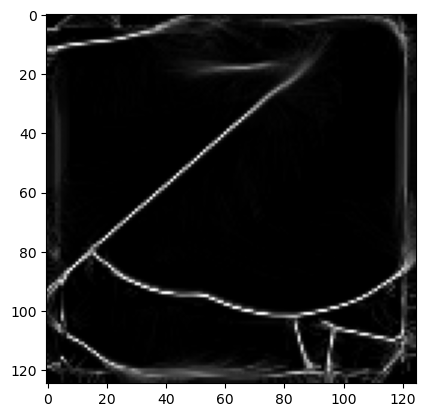

In [199]:
plt.imshow(batch[0][0][3], cmap = "grey")

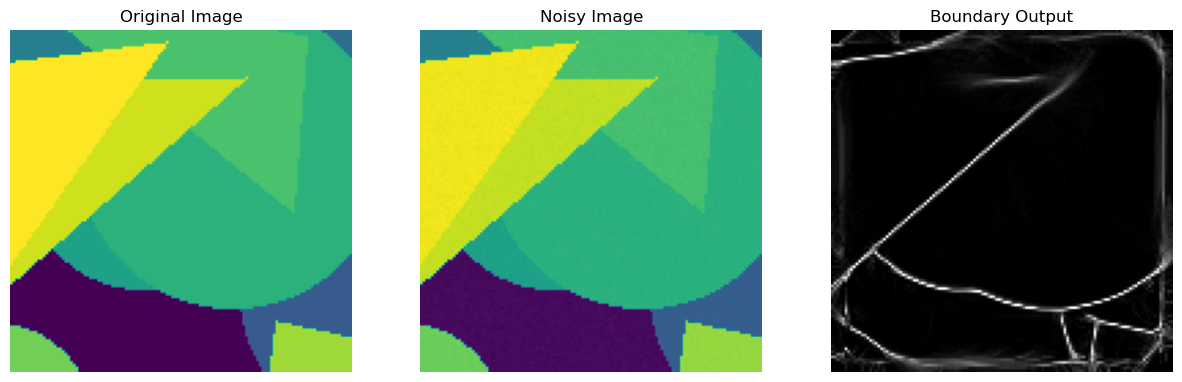

In [220]:
plot_outputs(batch[0][0])